In [1]:
import numpy as np

# plot
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# dataset
from sklearn.datasets import make_moons, make_classification

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# result metrics
from sklearn.metrics import accuracy_score

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# ensemble meta-classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

### Global parameters

In [2]:
MESH_STEP = 0.02
N_SAMPLES = 2000
DATA_NOISE = 0.2
TEST_SIZE = 0.2

### Preprocess dataset

In [3]:
dataset = make_moons(n_samples=N_SAMPLES, noise=DATA_NOISE)

In [4]:
X, y = dataset
X = StandardScaler().fit_transform(X)
dataset_split = train_test_split(X, y, test_size=TEST_SIZE)
X_train, X_test, y_train, y_test = dataset_split

In [5]:
def graph_limits(dataset_split):
    """
    Returns the x-axis and y-axis limits for the dataset
    """
    X_train, X_test, y_train, y_test = dataset_split
    
    # x-axis limits
    x_min = min( X_train[:, 0].min(), X_test[:, 0].min() ) - 0.5
    x_max = max( X_train[:, 0].max(), X_test[:, 0].max()) + 0.5
    # y-axis limits (not y the category!)
    y_min = min( X_train[:, 1].min(), X_test[:, 1].min() ) - 0.5
    y_max = max( X_train[:, 1].max(), X_test[:, 1].max() ) + 0.5
    
    return x_min, x_max, y_min, y_max    

def scatter_datapoints(ax, dataset_split):
    X_train, X_test, y_train, y_test = dataset_split
    cmap = ListedColormap(['r', 'b'])

    # Plot the training points (as regular points)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap, edgecolors='k')
    # Plot the testing points (as '*')
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap, s=300, marker='*', edgecolors='k')

def plot_dataset(dataset_split):
    figure = plt.figure(figsize=(27, 9))
    ax = plt.axes()

    x_min, x_max, y_min, y_max = graph_limits(dataset_split)

    scatter_datapoints(ax, dataset_split)
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

    plt.tight_layout()
    plt.show()

In [6]:
def compare_classifiers_plot(dataset_split, classifiers, clf_names):
    """
    Plot decision boundaries for a set of classifiers and compare their respective accuracies
    """
    figure = plt.figure(figsize=(33, 20))

    X_train, X_test, y_train, y_test = dataset_split
    
    for (i, (clf_name, clf)) in enumerate(zip(clf_names, classifiers)):
        clf.fit(X_train, y_train)
        y_pred_in = clf.predict(X_train)
        y_pred = clf.predict(X_test)

        ax = plt.subplot(int(np.ceil(len(classifiers)/2)), 3, i+1)

        # show datapoints
        scatter_datapoints(ax, dataset_split)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        x_min, x_max, y_min, y_max = graph_limits(dataset_split)

        xx, yy = np.meshgrid(np.arange(x_min, x_max, MESH_STEP),
                             np.arange(y_min, y_max, MESH_STEP))

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh based on the likehood of correct classification
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=.6)

        in_acc = accuracy_score(y_train, y_pred_in)
        out_acc = accuracy_score(y_test, y_pred)
        
        plt.xlabel('{}\nIn: {:.2%}\nOut: {:.2%}'.format(clf_name, in_acc, out_acc), fontsize=22)

    plt.tight_layout()
    plt.show()

### Classifiers

In [7]:
MIN_SAMPLE_LEAF = 1
MAX_DEPTH = 5
MAX_LEAF_NODES= 8
N_ESTIMATORS = 200
MAX_SAMPLES = 50

In [8]:
log_clf = LogisticRegression(solver='lbfgs')

decision_tree_clf = DecisionTreeClassifier(
    max_leaf_nodes=MAX_LEAF_NODES, 
    max_depth=MAX_DEPTH, 
    min_samples_leaf=MIN_SAMPLE_LEAF
)

random_forest_clf = RandomForestClassifier(
    n_estimators=N_ESTIMATORS, 
    max_leaf_nodes=MAX_LEAF_NODES, 
    n_jobs=-1
) # n_jobs=-1 : use all available CPU cores

svm_clf = SVC(
    gamma='auto',
    probability=True
)

In [9]:
classifiers = [
    log_clf,
    decision_tree_clf,
    random_forest_clf,
    svm_clf,
]

clf_names = [
    'Logistic Regression',
    'Decision Tree',
    'Random Forest',
    'SVM',
]

### Ensemble Classifiers

In [10]:
decision_tree_bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_leaf_nodes=MAX_LEAF_NODES, max_depth=MAX_DEPTH, min_samples_leaf=MIN_SAMPLE_LEAF),
    n_estimators=N_ESTIMATORS,
    max_samples=MAX_SAMPLES,
    bootstrap=True,
    n_jobs=-1,
)

soft_voting_clf = VotingClassifier(
    estimators=list(zip(clf_names, classifiers)),
    voting='soft',
)

decision_tree_ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_leaf_nodes=MAX_LEAF_NODES, max_depth=MAX_DEPTH, min_samples_leaf=MIN_SAMPLE_LEAF),
    n_estimators=N_ESTIMATORS,
    algorithm='SAMME.R',
    learning_rate=0.5,
)

In [11]:
ens_classifiers = [
    soft_voting_clf,
    decision_tree_bag_clf,
    decision_tree_ada_clf
]

ens_clf_names = [
    'Soft Voting',
    'Decision Tree Bagging',
    'Decision Tree Boosting',
]

## Compare them all

In [12]:
all_classifiers = classifiers+ens_classifiers
all_clf_names = clf_names+ens_clf_names

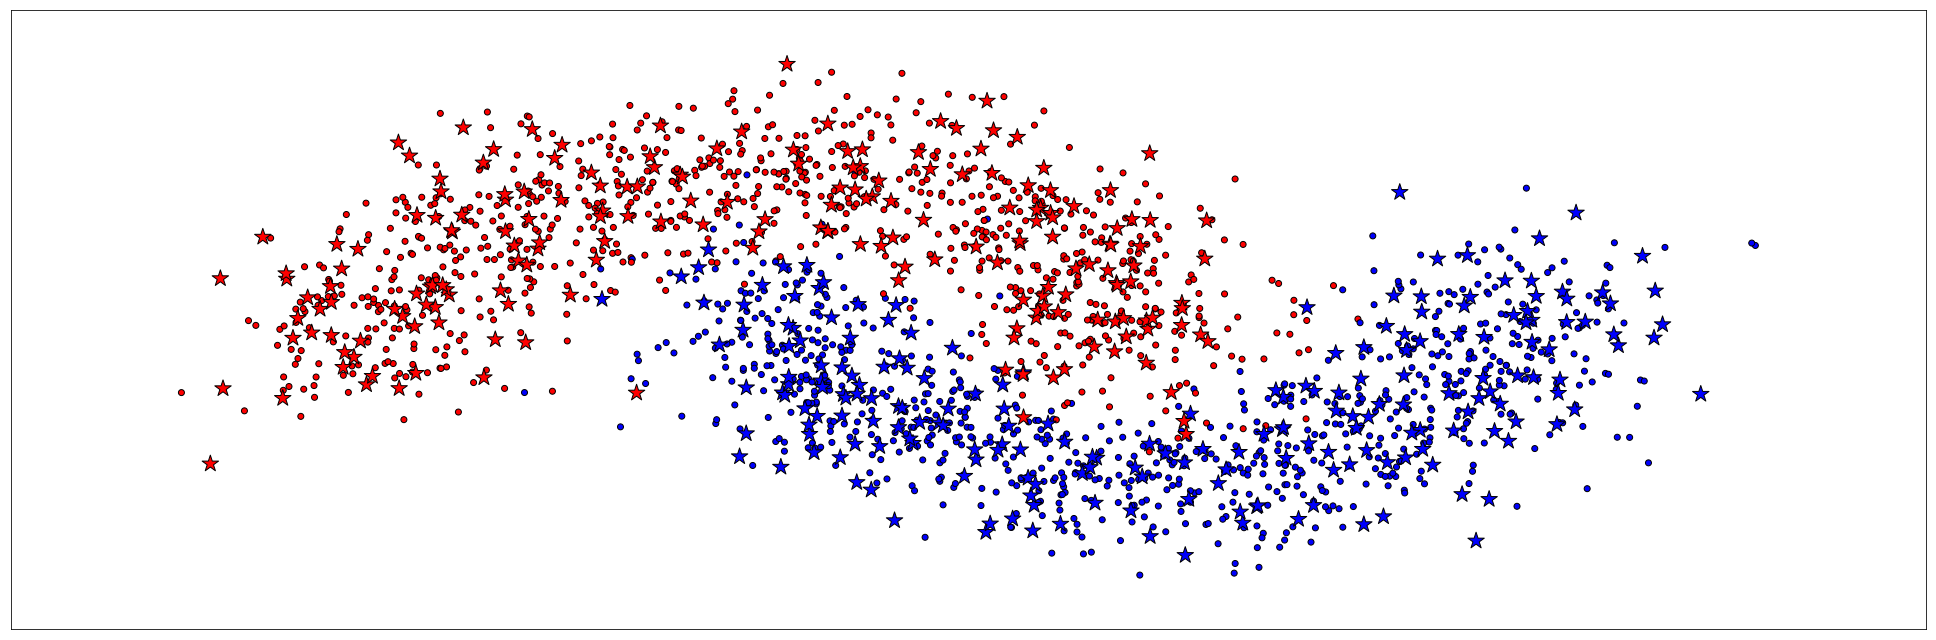

In [13]:
plot_dataset(dataset_split)

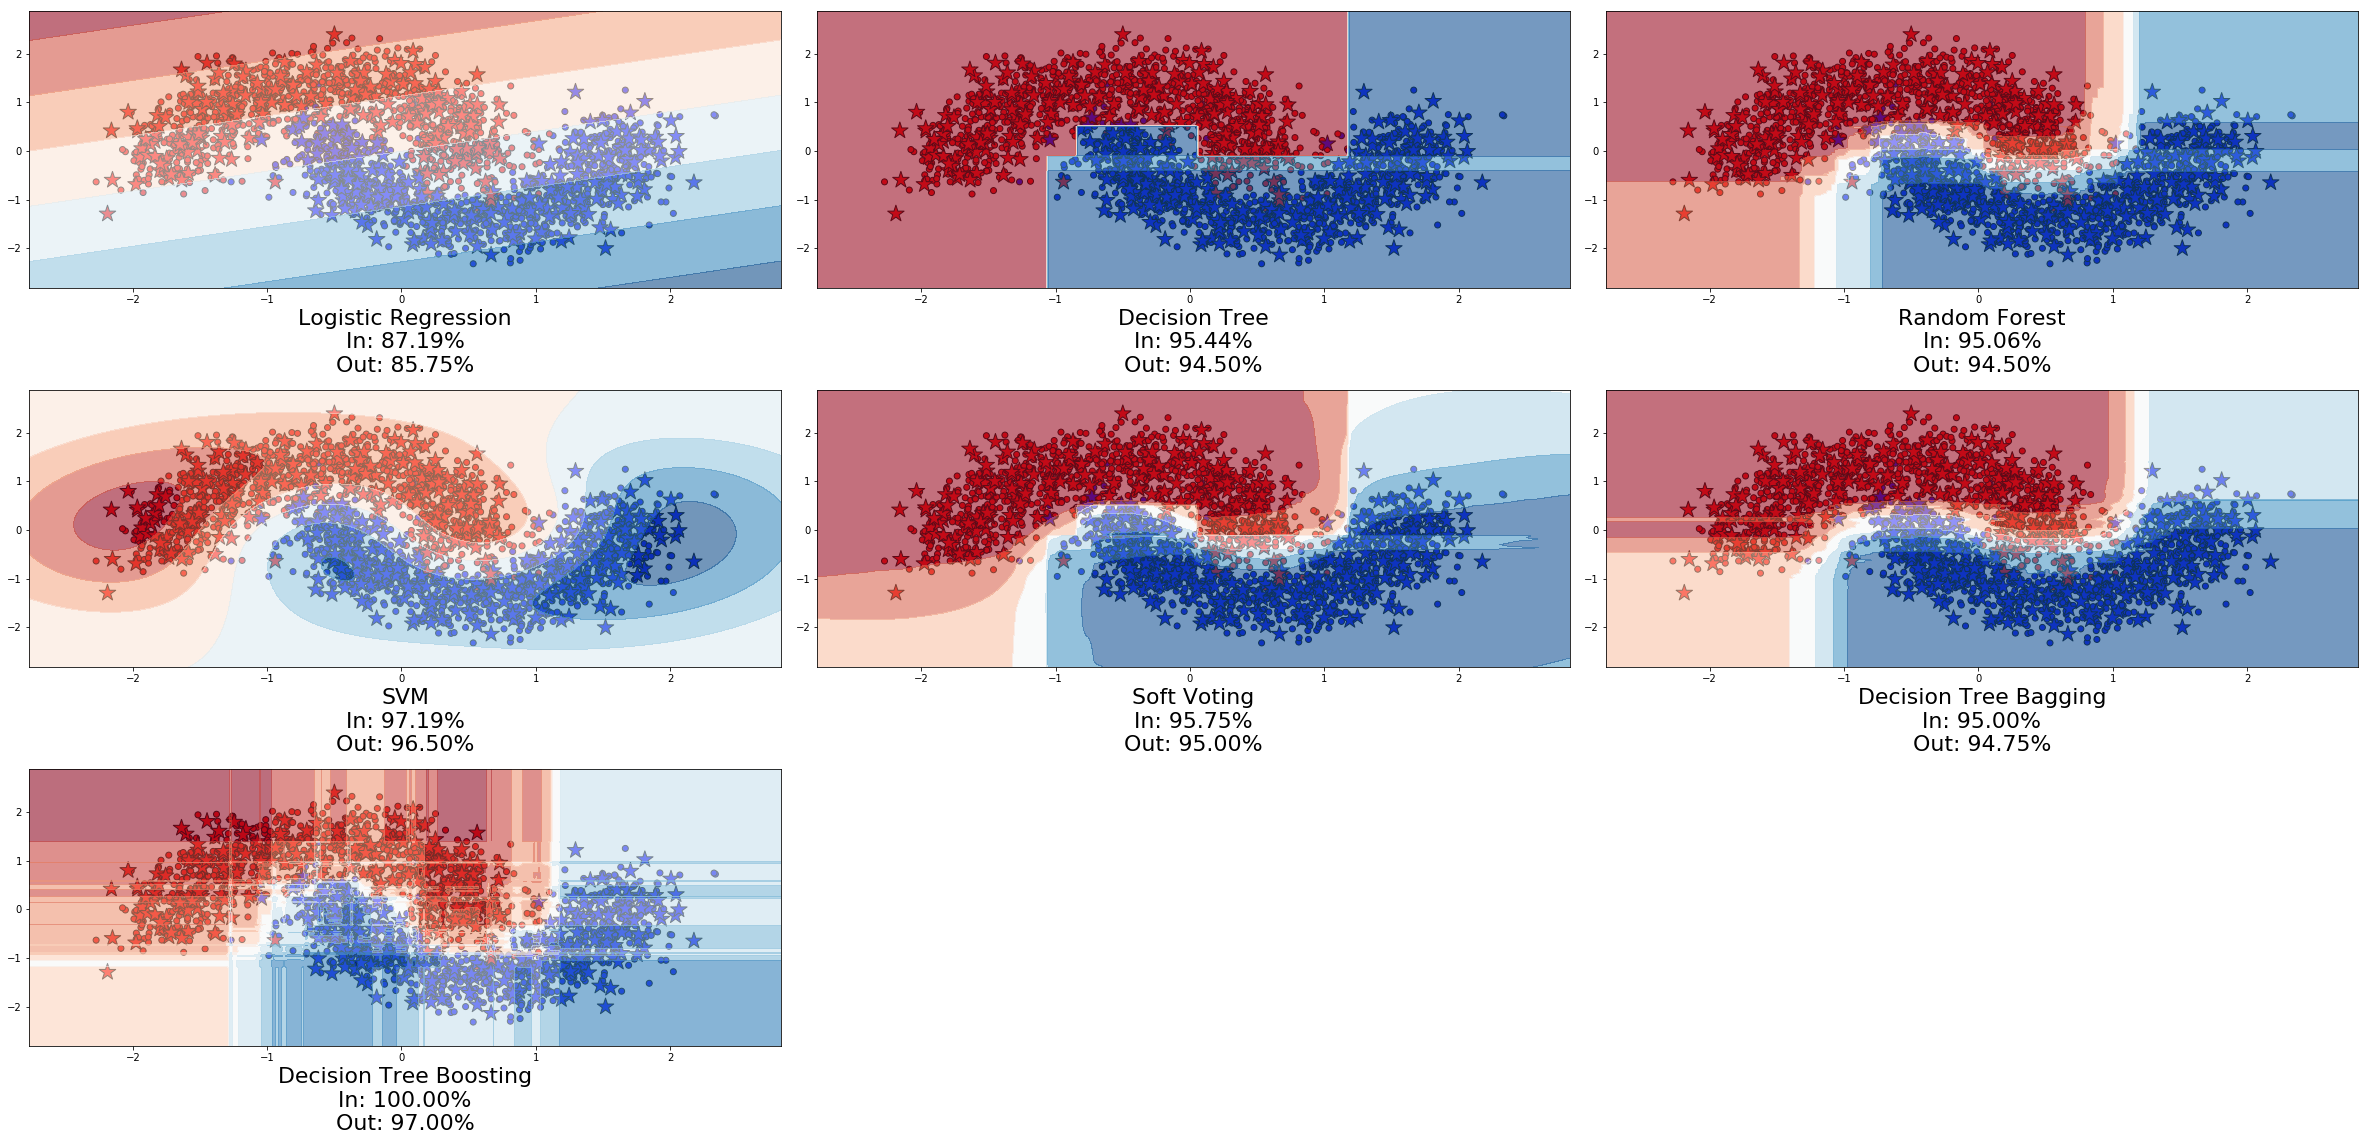

In [14]:
compare_classifiers_plot(dataset_split, all_classifiers, all_clf_names)

AdaBoost is a clear outperformer with low noise data...

## Redo the experiment with more noise

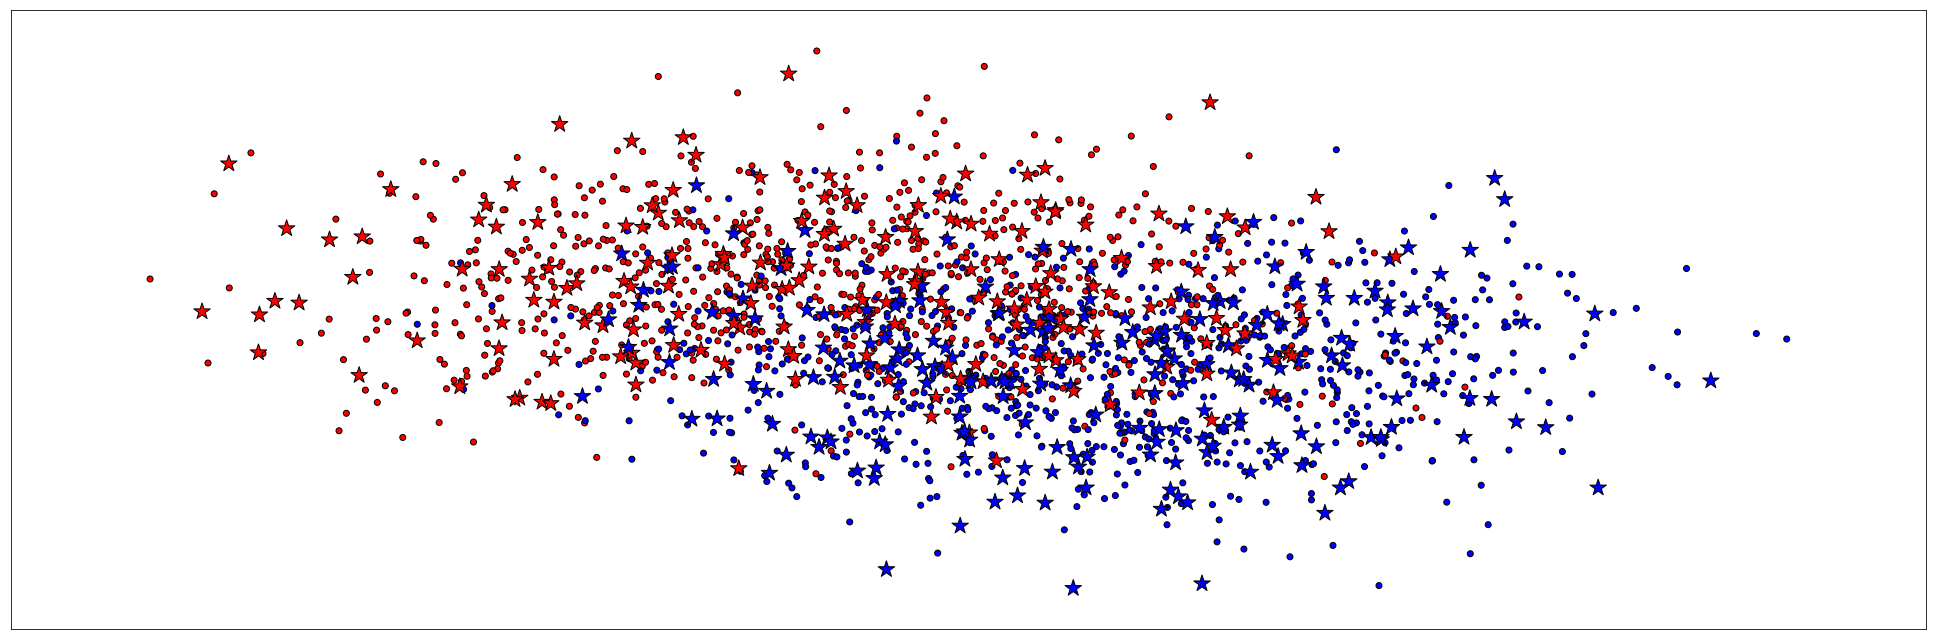

In [15]:
DATA_NOISE = 0.6
dataset = make_moons(n_samples=N_SAMPLES, noise=DATA_NOISE)
X, y = dataset
X = StandardScaler().fit_transform(X)
dataset_split = train_test_split(X, y, test_size=TEST_SIZE)
X_train, X_test, y_train, y_test = dataset_split
plot_dataset(dataset_split)

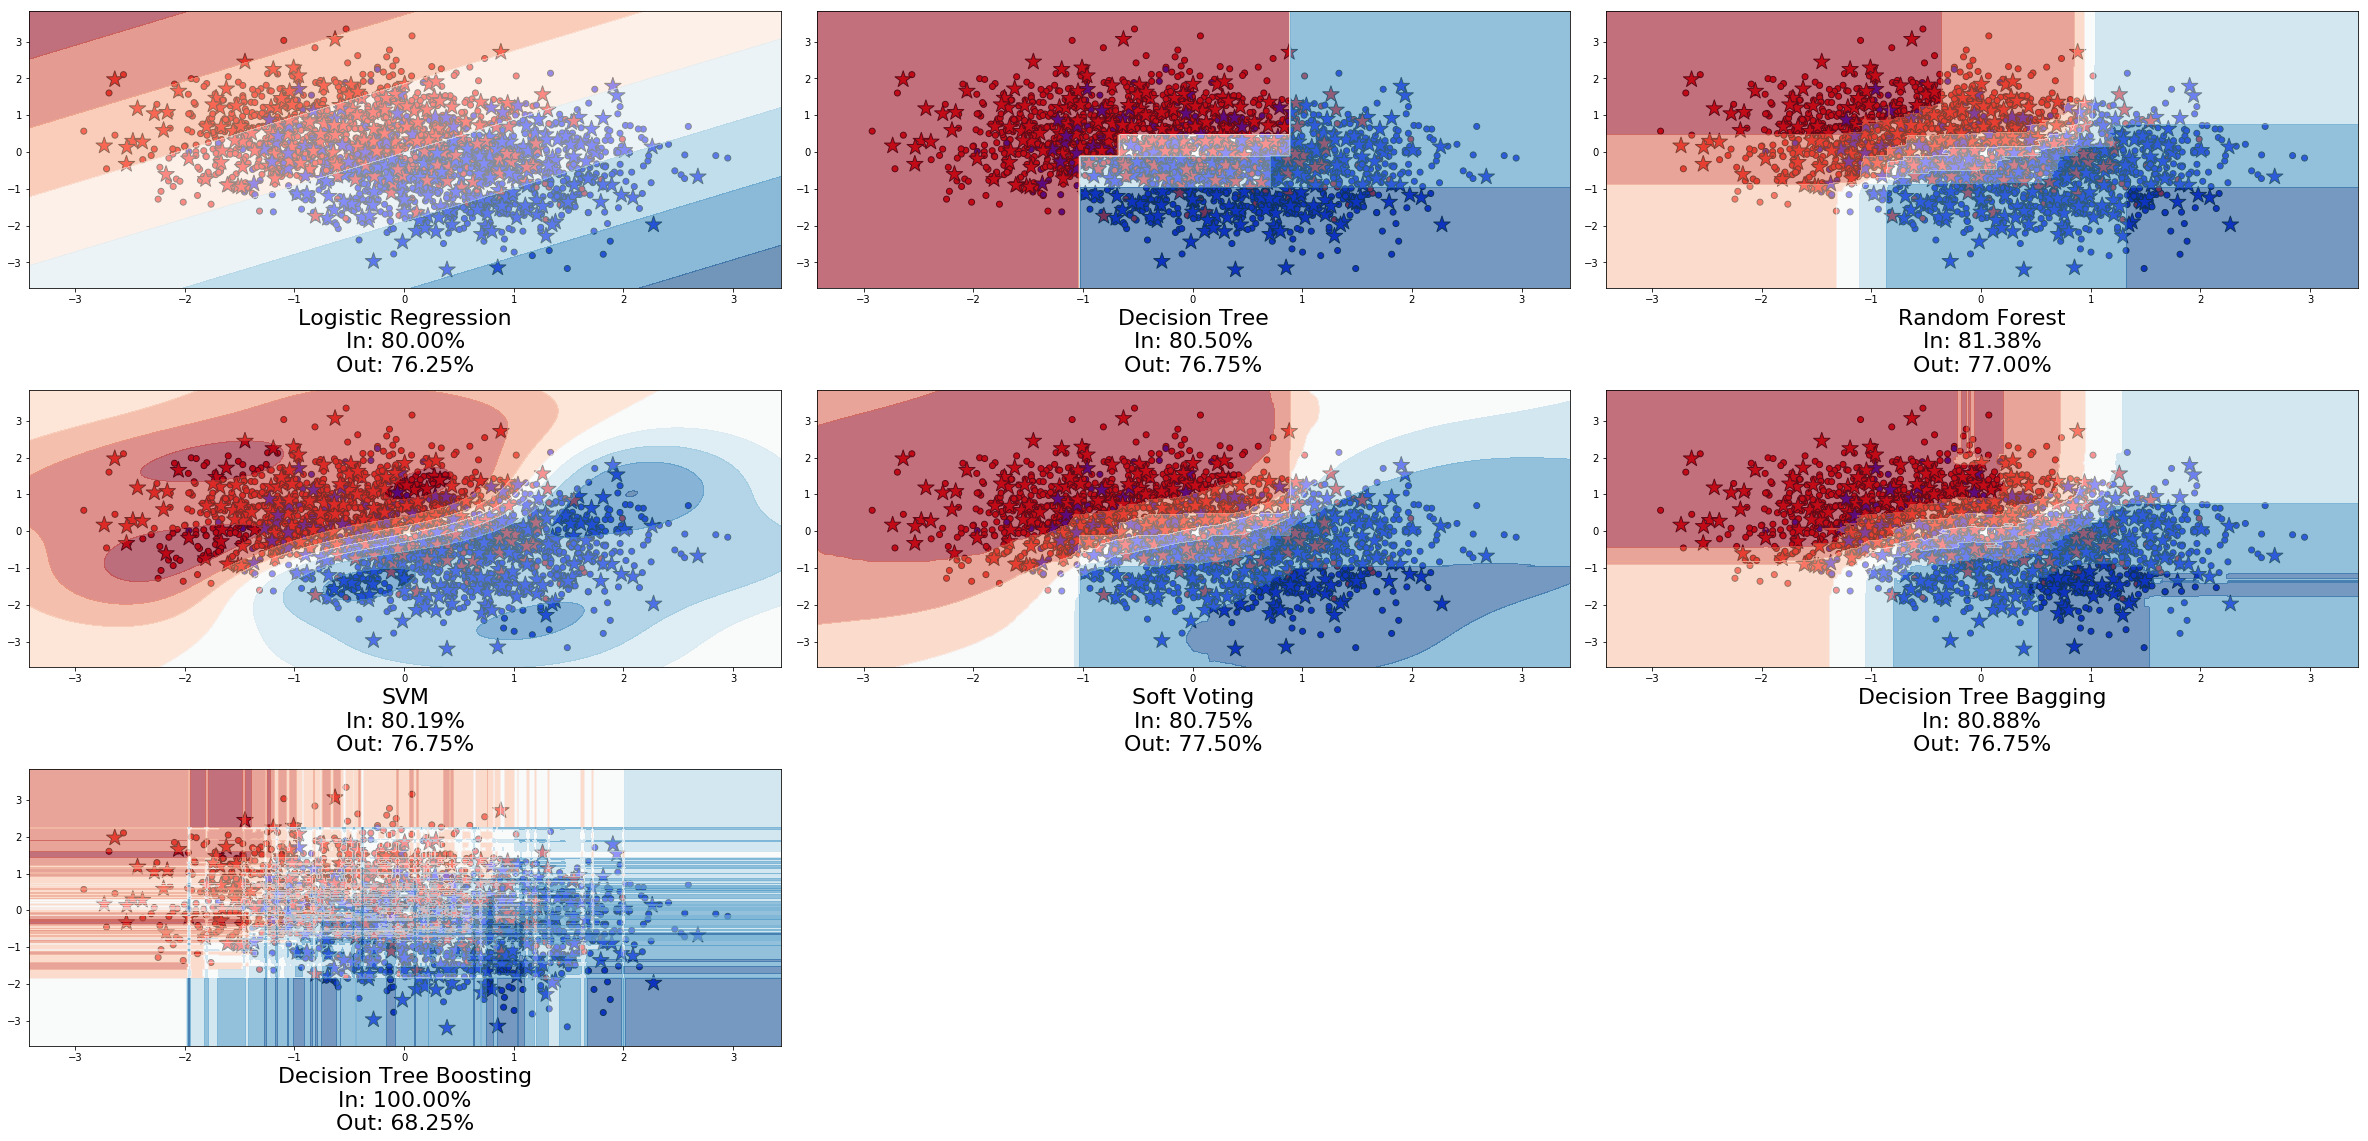

In [16]:
all_classifiers = classifiers+ens_classifiers
all_clf_names = clf_names+ens_clf_names
compare_classifiers_plot(dataset_split, all_classifiers, all_clf_names)

AdaBoost is easily prone to overfitting and very sensible to noise!